In [1]:
from pynq import GPIO

from time import sleep
from doa_mts import *
o1 = doaMtsOverlay('doa_mts.bit')

In [2]:
import numpy as np
data_size = 1024*2
# data = o1.get_custom_data(data_size)
AlignedCaptureSamples = np.zeros((1,len(o1.adc_capture)),dtype=np.int16)
o1.internal_capture(AlignedCaptureSamples)

iq_prod = np.zeros((1,len(o1.adc_prod)),dtype=np.int32)
o1.prod_capture(iq_prod)
print(iq_prod[0][0:data_size])
print(AlignedCaptureSamples[0][0:data_size])

[  66836   39537   55234 ...  316574 -301734  407246]
[-353 -474 -615 ...   66 -919 -795]


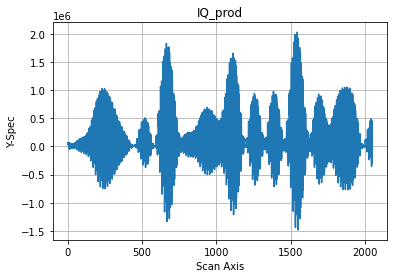

In [3]:

import matplotlib.pyplot as plt
plt.plot(iq_prod[0][0:data_size])

plt.xlabel('Scan Axis')
plt.ylabel('Y-Spec')
plt.title('IQ_prod')
plt.grid(True)
plt.show()

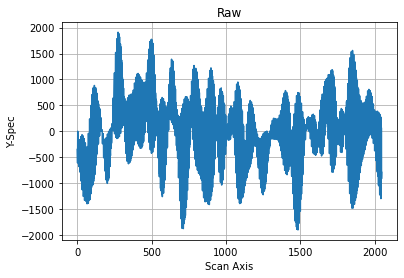

In [4]:

import matplotlib.pyplot as plt
plt.plot(AlignedCaptureSamples[0][0:data_size])

plt.xlabel('Scan Axis')
plt.ylabel('Y-Spec')
plt.title('Raw')
plt.grid(True)
plt.show()

In [5]:
mult = 32
N_iq = len(o1.adc_prod) // mult
iq_prod_streams = np.zeros((mult, N_iq), dtype=np.int32)
for i in range(mult):
    iq_prod_streams[i] = iq_prod[0][i::mult]

In [6]:
fasfasf

NameError: name 'fasfasf' is not defined

In [7]:
import numpy as np
import matplotlib.pyplot as plt

fc = 5.7e9
min_ang = -90 # min scanning angle
max_ang = 90 # max scanning angle
scan_res = 0.1 # scan resolution
scan_axis = list(np.arange(min_ang, max_ang+1, scan_res)) # angles axis
num_elements = 4
c = 299792458
lbd = c / fc
d = lbd/2


channels = 8 # 4 I + 4 Q
N = len(o1.adc_capture) // channels

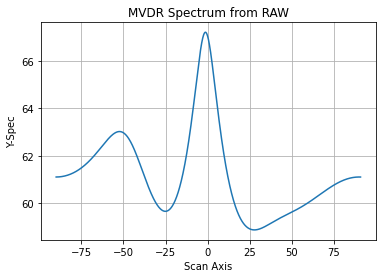

-1.300000000005042


In [78]:
# Data acq from FPGA
# AlignedCaptureSamples = np.zeros((1,len(o1.adc_capture)),dtype=np.int16)
# o1.internal_capture(AlignedCaptureSamples)


ShapedCaptureSamples = np.zeros((channels, N), dtype=np.int16)
for i in range(channels):
    ShapedCaptureSamples[i] = AlignedCaptureSamples[0][i::channels]

iqData = np.zeros((4, N), dtype=np.cdouble)
idx = 0
for i in range(0, channels, 2):
    iqData[idx] = np.conjugate(ShapedCaptureSamples[i] - 1j * ShapedCaptureSamples[i+1])
    idx = idx + 1

rawData = iqData

R = rawData@np.conjugate(rawData.T)

# MVDR
Rx = R  # Data covariance matrix
Rx_Inv = np.linalg.inv(Rx)  # Inverse of covariance matrix
num_elements = 4  # Define the number of elements and set its value
A = np.zeros(num_elements, dtype=complex)

# Assuming scan_axis is already defined as a numpy array
yspec = np.zeros(len(scan_axis))

# Calculate yspec
for t in range(len(scan_axis)):
    A = np.exp(-1j * 2 * np.pi * d * np.arange(num_elements) * np.sin(np.radians(scan_axis[t])) / lbd)
    B = np.conj(np.transpose(A))@Rx_Inv@A
    yspec[t] = 10 * np.log10(np.abs(1 / B))

# Plot data
plt.plot(scan_axis, yspec)
plt.xlabel('Scan Axis')
plt.ylabel('Y-Spec')
plt.title('MVDR Spectrum from RAW')
plt.grid(True)
plt.show()
ang_raw = scan_axis[np.argmax(yspec)]
power = round(np.max(yspec))
print(ang_raw)
yspec_old = yspec

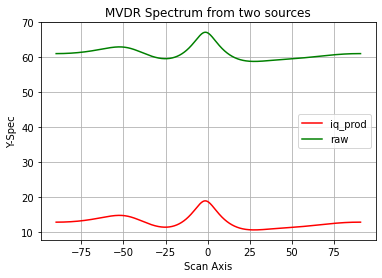

-1.4000000000050363 -1.300000000005042


In [80]:
data = iq_prod[0]
# Data acq from FPGA
# AlignedCaptureSamples = np.zeros((1,len(o1.adc_capture)),dtype=np.int16)
# o1.internal_capture(AlignedCaptureSamples)
mults = 16
length_data = len(data)
length_ = round(length_data / mults)
raw = np.zeros((mults, length_))

for i in range(mults):
    raw[i] = data[i::mults]

raw_s = raw
# rawc = raw.astype(np.complex128)
rawc = raw
idd = 1
zer = np.zeros((1, rawc.shape[1]))
rawc = np.insert(rawc, [1, 8, 13, 16], [zer], axis=0)

rawData_prod = np.zeros(((mults + 4)//2, rawc.shape[1]), dtype=np.complex128)
idd = 0
for n in range(0, mults + 4, 2):
    rawData_prod[idd, :] = np.conjugate(rawc[n, :] - 1j * rawc[n+1, :])
    idd += 1
    
rawData_prod = rawData_prod*2

R[0,0] = np.mean(rawData_prod[0])
R[0,1] = np.mean(rawData_prod[1])
R[0,2] = np.mean(rawData_prod[2])
R[0,3] = np.mean(rawData_prod[3])
R[1,0] = np.conj(R[0,1])
R[1,1] = np.mean(rawData_prod[4])
R[1,2] = np.mean(rawData_prod[5])
R[1,3] = np.mean(rawData_prod[6])
R[2,0] = np.conj(R[0,2])
R[2,1] = np.conj(R[1,2])
R[2,2] = np.mean(rawData_prod[7])
R[2,3] = np.mean(rawData_prod[8])
R[3,0] = np.conj(R[0,3])
R[3,1] = np.conj(R[1,3])
R[3,2] = np.conj(R[2,3])
R[3,3] = np.mean(rawData_prod[9])
   
    
# MVDR
Rx = R  # Data covariance matrix
Rx_Inv = np.linalg.inv(Rx)  # Inverse of covariance matrix
num_elements = 4  # Define the number of elements and set its value
A = np.zeros(num_elements, dtype=complex)

# Assuming scan_axis is already defined as a numpy array
yspec = np.zeros(len(scan_axis))

# Calculate yspec
for t in range(len(scan_axis)):
    A = np.exp(-1j * 2 * np.pi * d * np.arange(num_elements) * np.sin(np.radians(scan_axis[t])) / lbd)
    B = np.conj(np.transpose(A))@Rx_Inv@A
    yspec[t] = 10 * np.log10(np.abs(1 / B))

# Plot data
# plt.plot(scan_axis, yspec)
plt.plot(scan_axis, yspec, color='r', label='iq_prod') 
plt.plot(scan_axis, yspec_old, color='g', label='raw') 
plt.xlabel('Scan Axis')
plt.ylabel('Y-Spec')
plt.title('MVDR Spectrum from two sources')
plt.legend()
plt.grid(True)
plt.show()
ang_prod = scan_axis[np.argmax(yspec)]
power = round(np.max(yspec))
print(ang_prod, ang_raw)    

0
1
2
3
4
5
6
7
8
9


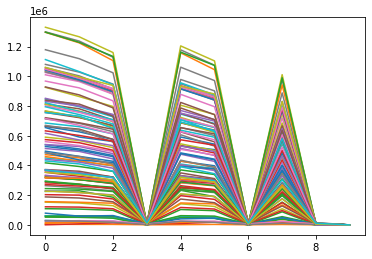

In [40]:
delay = 8

cnt = 0
prod = np.zeros((rawData_prod.shape[0], rawData.shape[1]), dtype=complex)
streams = channels // 2
for i in range(streams):
    for j in range(i, streams):
        print(cnt)
        prod[cnt] = rawData[i] * np.conj(rawData[j])
        cnt += 1
        

prod_c = prod[:,:rawData_prod.shape[1] - delay] / 2
rawData_prod_d = rawData_prod[:,delay:]
diff = np.abs(prod_c - rawData_prod_d)
plt.plot(diff[:,:100])
# plt.legend()
plt.show()

In [13]:
range(i, streams-1)

range(2, 3)

In [22]:
print(prod_c[:1, :10])
print(rawData_prod_d[:1, :10]) 

[[174642.5+0.j 227864.5+0.j 324752.5+0.j 468234.5+0.j 641961. +0.j
  799960.5+0.j 913373. +0.j 981296.5+0.j 976729. +0.j 920168.5+0.j]]
[[196432.+0.j 293904.+0.j 338244.+0.j 297450.+0.j 199940.+0.j  89140.+0.j
   21520.+0.j  34212.+0.j 117108.+0.j 208960.+0.j]]


In [74]:
AlignedCaptureSamples = np.zeros((1,len(o1.adc_capture)),dtype=np.int16)
o1.internal_capture(AlignedCaptureSamples)

iq_prod = np.zeros((1,len(o1.adc_prod)),dtype=np.int32)
o1.prod_capture(iq_prod)

In [26]:
from scipy.io import savemat
mdic3 = {"raw_p": rawc, "label": "raw_p"}
savemat("raw.mat", mdic3)

In [26]:
from scipy.io import savemat
mdic3 = {"raw_p": rawc, "label": "raw_p"}
savemat("raw.mat", mdic3)

In [ ]:
len(rawc[1,:])


In [ ]:
a = [1, 1, 1, 1, 1]
a = np.insert(a, [1, 3], 0)
print(a)

In [ ]:
rawn = np.insert(rawc, [1, 9, 13, 15], zer, axis=1)

In [ ]:
rawn = np.insert(rawc, [1, 2], zer)

In [ ]:
rawn[2:]

In [ ]:
a = np.array([[1, 2], [3, 4]])
a = np.insert(a, [0, 2], [0, 0], axis=0)
print(a)

In [ ]:
rawn = np.insert(rawc, [1, 9, 13, 15], [zer], axis=0)

In [ ]:
zer = np.zeros((1, rawc.shape[1]))

In [ ]:
t = np.zeros((4, 4))
t[1,1] = 1
print(t)